In [1]:
import os

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

from NeuralNet import Net

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from data import processing_data
from evaluation import visualize_results
from settings import BASE_DIR, DEVICE
import pandas as pd

In [2]:
data_path = os.path.join(BASE_DIR,"dataset", 'train.csv')

df = pd.read_csv(data_path)
df

,genres,rating,no_of_votes,meta_score,release_date,gross,budget,countries,log_budget,log_no_of_votes,log_gross,log_gross_bin
0,"Supernatural Horror, Vampire Horror, Horror, T...",5.6,33000,47.000000,2024.0,851156.0,26000000.0,United States,17.073607,10.404293,13.654352,1
1,"Drama, Music, Romance",5.6,23000,55.000000,2017.0,1813453.0,26000000.0,United States,17.073607,10.043293,14.410744,1
2,"Computer Animation, Adventure, Animation, Come...",6.0,18000,53.000000,2023.0,209646030.0,95000000.0,"United States, United Kingdom",18.369387,9.798183,19.160931,8
3,"Body Horror, Folk Horror, Monster Horror, Supe...",4.5,12000,45.000000,2024.0,2014050.0,20000000.0,"United States, United Kingdom, Germany, Bulgaria",16.811243,9.392745,14.515659,1
4,"Steamy Romance, Drama, Romance",6.0,27000,64.812903,2010.0,844281.0,26000000.0,Spain,17.073607,10.203629,13.646242,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1795,"Buddy Cop, Bumbling Detective, Slapstick, Acti...",7.4,391000,70.000000,2016.0,71261763.0,50000000.0,United States,17.727534,12.876465,18.081870,6
1796,"Basketball, Teen Fantasy, Comedy, Family, Fant...",5.4,23000,47.000000,2002.0,62274780.0,30000000.0,United States,17.216708,10.043293,17.947067,5
1797,"Coming-of-Age, Teen Drama, Action, Drama, Fami...",5.3,73000,36.000000,1989.0,38956288.0,26000000.0,United States,17.073607,11.198228,17.477951,4
1798,"Desert Adventure, Sci-Fi Epic, Space Sci-Fi, A...",6.3,187000,41.000000,1984.0,31502161.0,40000000.0,"United States, Mexico",17.504390,12.138869,17.265567,4


In [3]:
PATIENCE = [50, 100, 150]
BATCH_SIZES = [64, 128, 256, 516]
LEARNING_RATES = [0.001, 0.005, 0.01]
HIDDEN_LAYERS = [2, 3]
DROPOUT_RATES = [0.1, 0.2, 0.3, 0.5]
EPOCHS = 2000
BEST_MODEL_DIR = os.path.join(BASE_DIR, "best_models", "neural_net")
n_iter = 10  # số lượng tổ hợp siêu tham số muốn thử
random_state = 42
param_grid = {
    "patience": PATIENCE,
    "learning_rate": LEARNING_RATES,
    "batch_size": BATCH_SIZES,
    "num_hidden_layers": HIDDEN_LAYERS,
    "dropout_rate": DROPOUT_RATES,
}

In [4]:
def train_model(X_train, y_train, X_val, y_val, params, fold):
    print(f"Training with params: {params}")
    batch_size = params["batch_size"]
    learning_rate = params["learning_rate"]
    patience = params["patience"]  # Lấy giá trị patience
    num_hidden_layers = params["num_hidden_layers"]
    dropout_rate = params["dropout_rate"]


    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = Net(X_train.shape[1], num_hidden_layers=num_hidden_layers,dropout_rate =dropout_rate ).to(DEVICE)
    criterion = nn.MSELoss().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=10, factor=0.5)

    best_val_loss = float("inf")
    patience_counter = 0
    save_path = os.path.join(BEST_MODEL_DIR, f"fold_{fold + 1}")
    best_model_path = os.path.join(save_path, "model.pt")
    os.makedirs(save_path, exist_ok=True)

    for epoch in range(EPOCHS):
        model.train()
        train_epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor.to(DEVICE))
            val_loss = criterion(val_preds, y_val_tensor.to(DEVICE)).item()
            scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            with open(os.path.join(save_path, "params.json"), "w") as f:
                json.dump(params, f)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return best_val_loss


=== Fold 1 ===
✅ Scaler saved to: H:\python\best_models\neural_net\fold_1\scaler.pkl
Training with params: {'patience': 50, 'num_hidden_layers': 3, 'learning_rate': 0.005, 'dropout_rate': 0.3, 'batch_size': 64}
Early stopping at epoch 178
Training with params: {'patience': 100, 'num_hidden_layers': 2, 'learning_rate': 0.01, 'dropout_rate': 0.1, 'batch_size': 256}
Early stopping at epoch 110
Training with params: {'patience': 100, 'num_hidden_layers': 3, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'batch_size': 516}
Early stopping at epoch 188
Training with params: {'patience': 50, 'num_hidden_layers': 2, 'learning_rate': 0.005, 'dropout_rate': 0.3, 'batch_size': 64}
Early stopping at epoch 55
Training with params: {'patience': 100, 'num_hidden_layers': 2, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'batch_size': 256}
Early stopping at epoch 386
Training with params: {'patience': 50, 'num_hidden_layers': 3, 'learning_rate': 0.005, 'dropout_rate': 0.1, 'batch_size': 64}
Early stopping

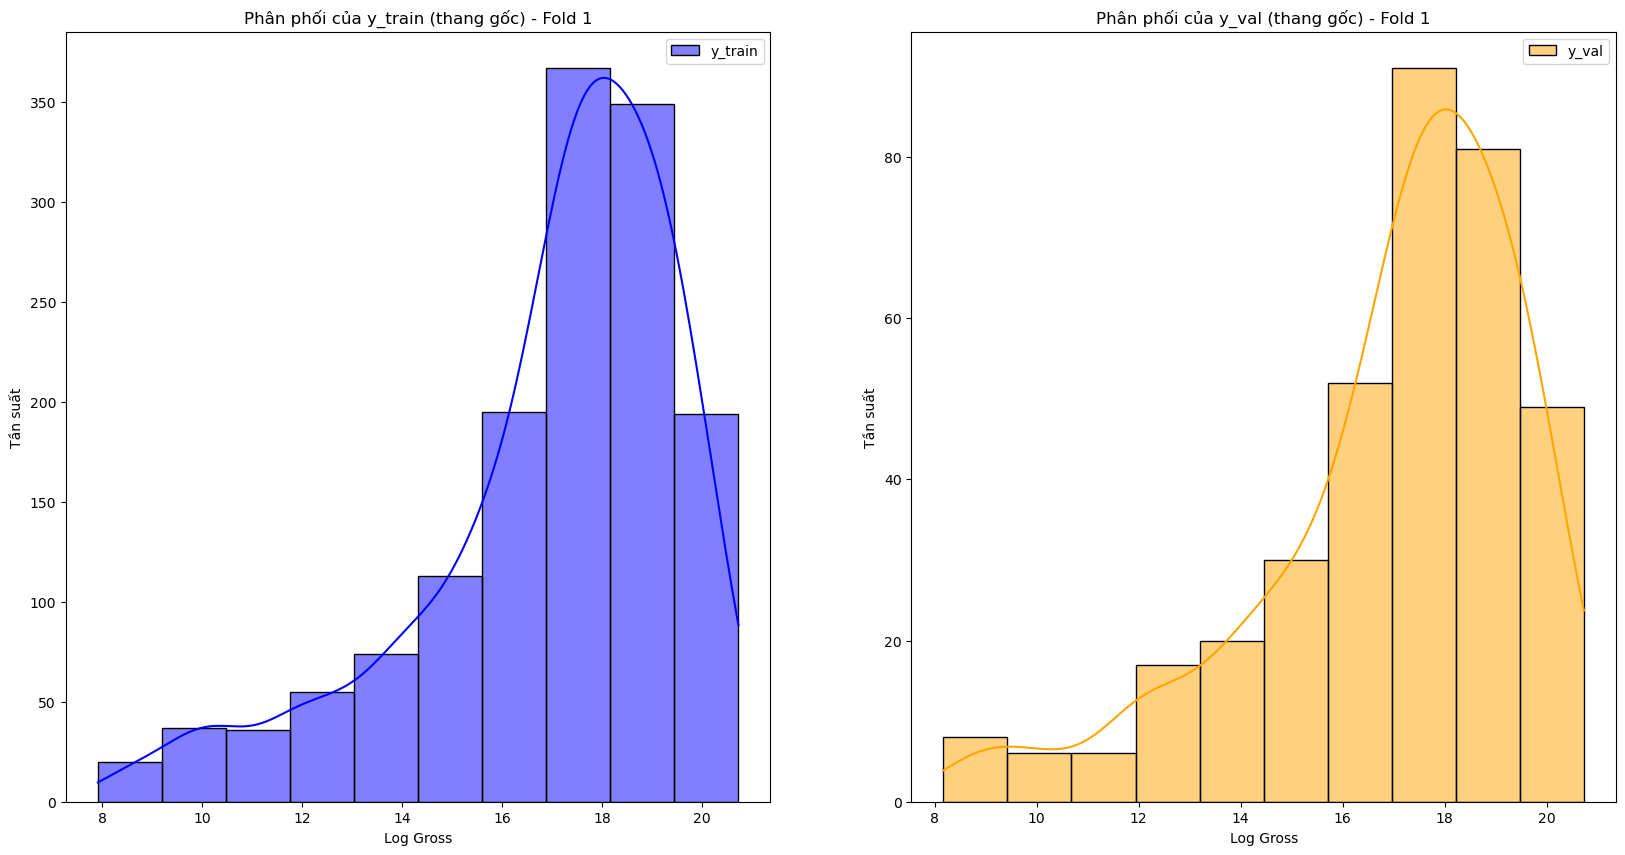

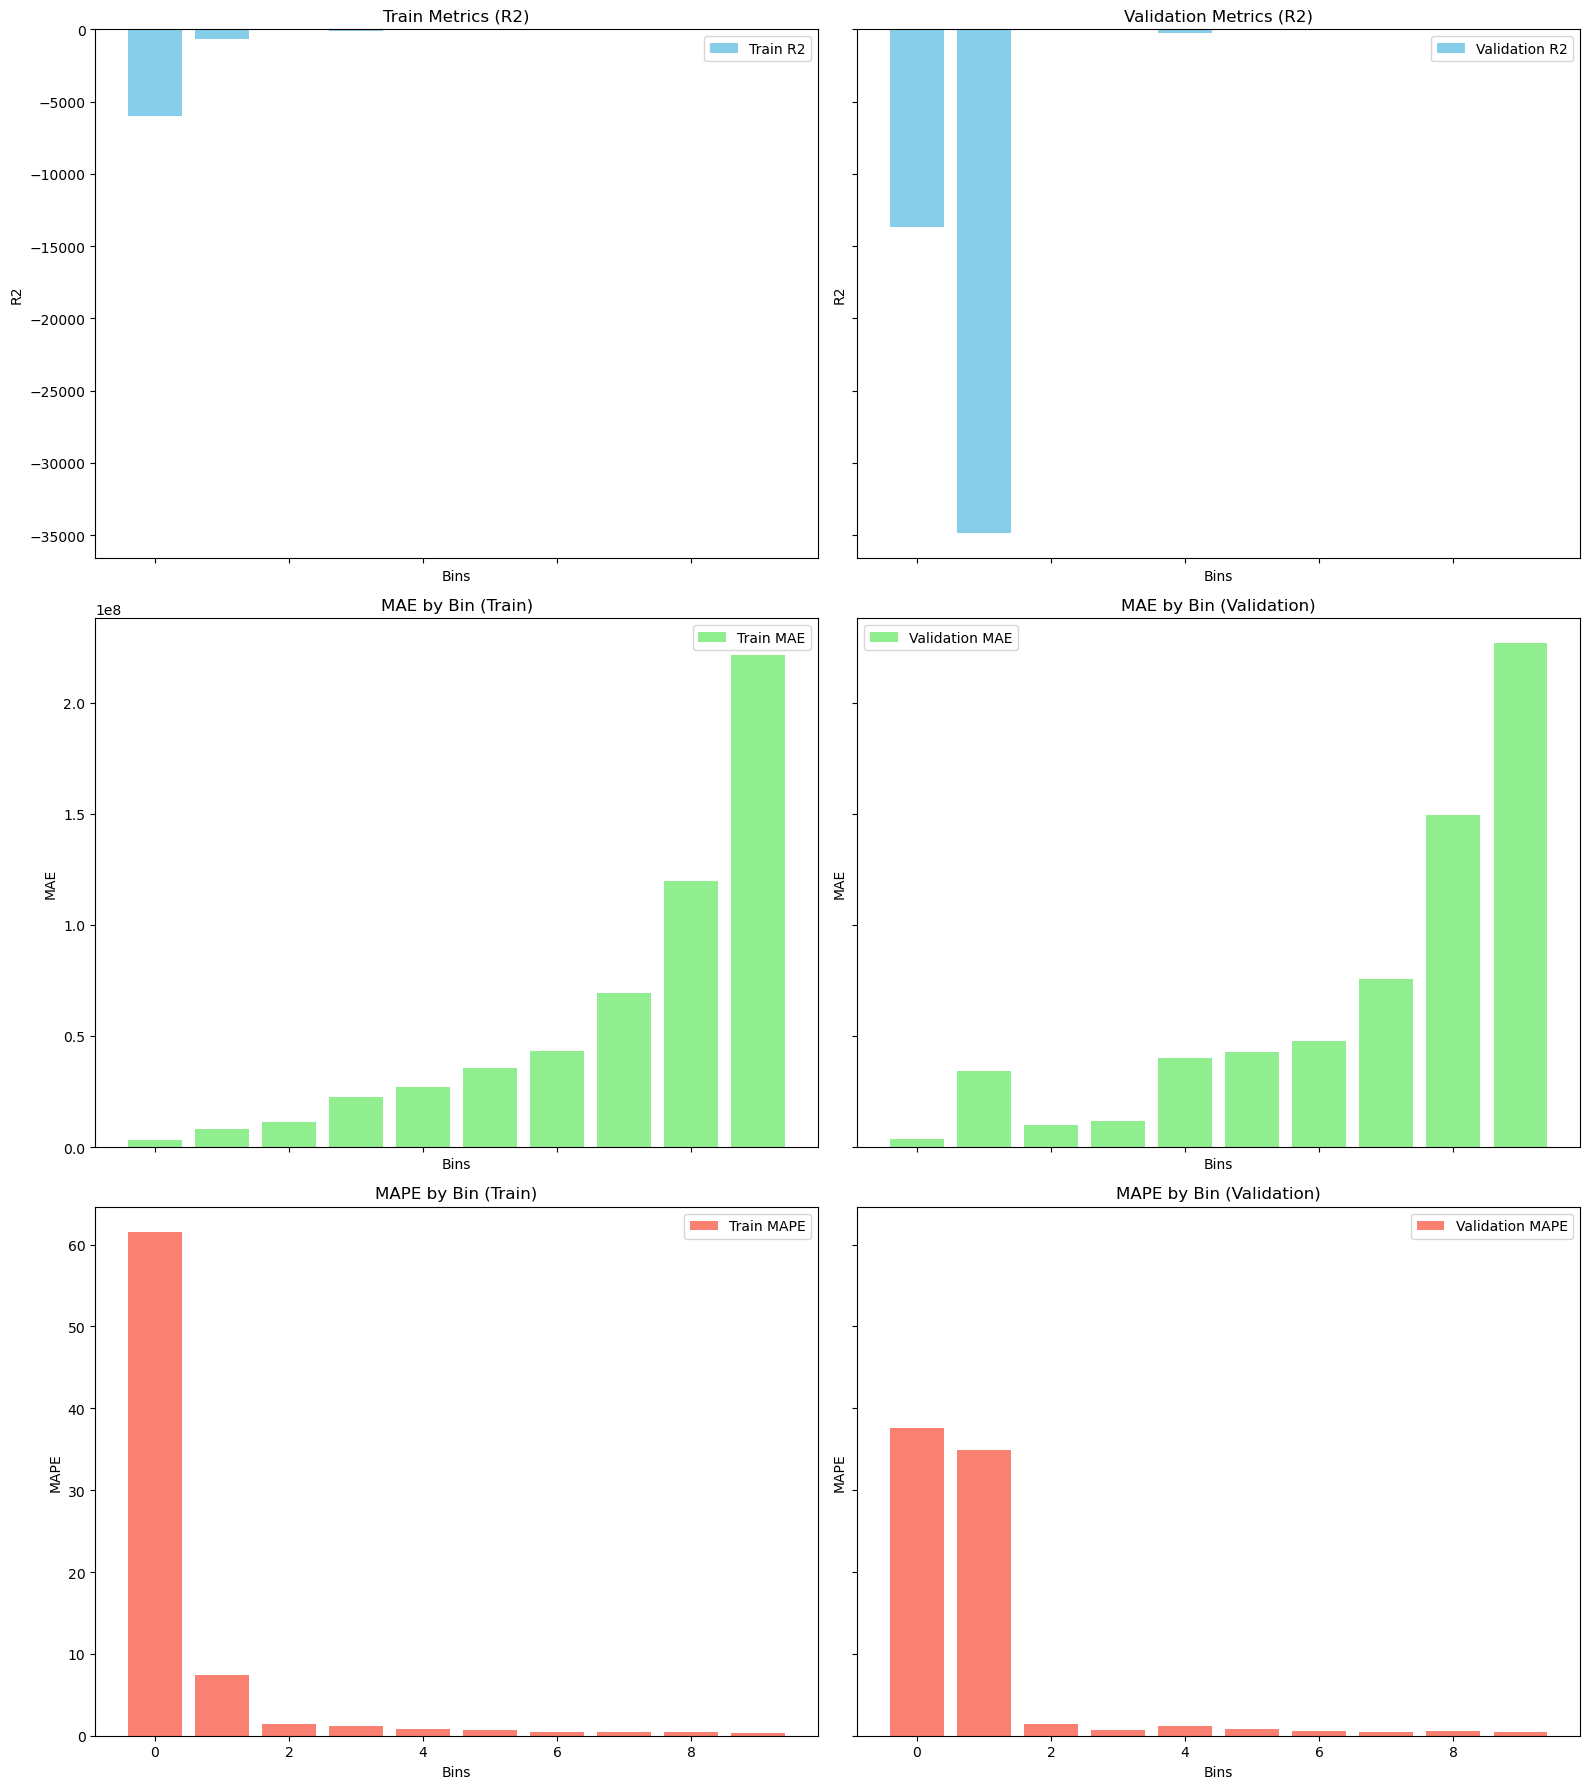


=== Fold 2 ===
✅ Scaler saved to: H:\python\best_models\neural_net\fold_2\scaler.pkl
Training with params: {'patience': 150, 'num_hidden_layers': 2, 'learning_rate': 0.005, 'dropout_rate': 0.2, 'batch_size': 516}
Early stopping at epoch 245
Training with params: {'patience': 150, 'num_hidden_layers': 3, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'batch_size': 64}
Early stopping at epoch 320
Training with params: {'patience': 100, 'num_hidden_layers': 3, 'learning_rate': 0.005, 'dropout_rate': 0.5, 'batch_size': 128}
Early stopping at epoch 146
Training with params: {'patience': 50, 'num_hidden_layers': 3, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 64}
Early stopping at epoch 168
Training with params: {'patience': 150, 'num_hidden_layers': 3, 'learning_rate': 0.005, 'dropout_rate': 0.5, 'batch_size': 128}
Early stopping at epoch 191
Training with params: {'patience': 150, 'num_hidden_layers': 3, 'learning_rate': 0.005, 'dropout_rate': 0.3, 'batch_size': 64}
Early stopp

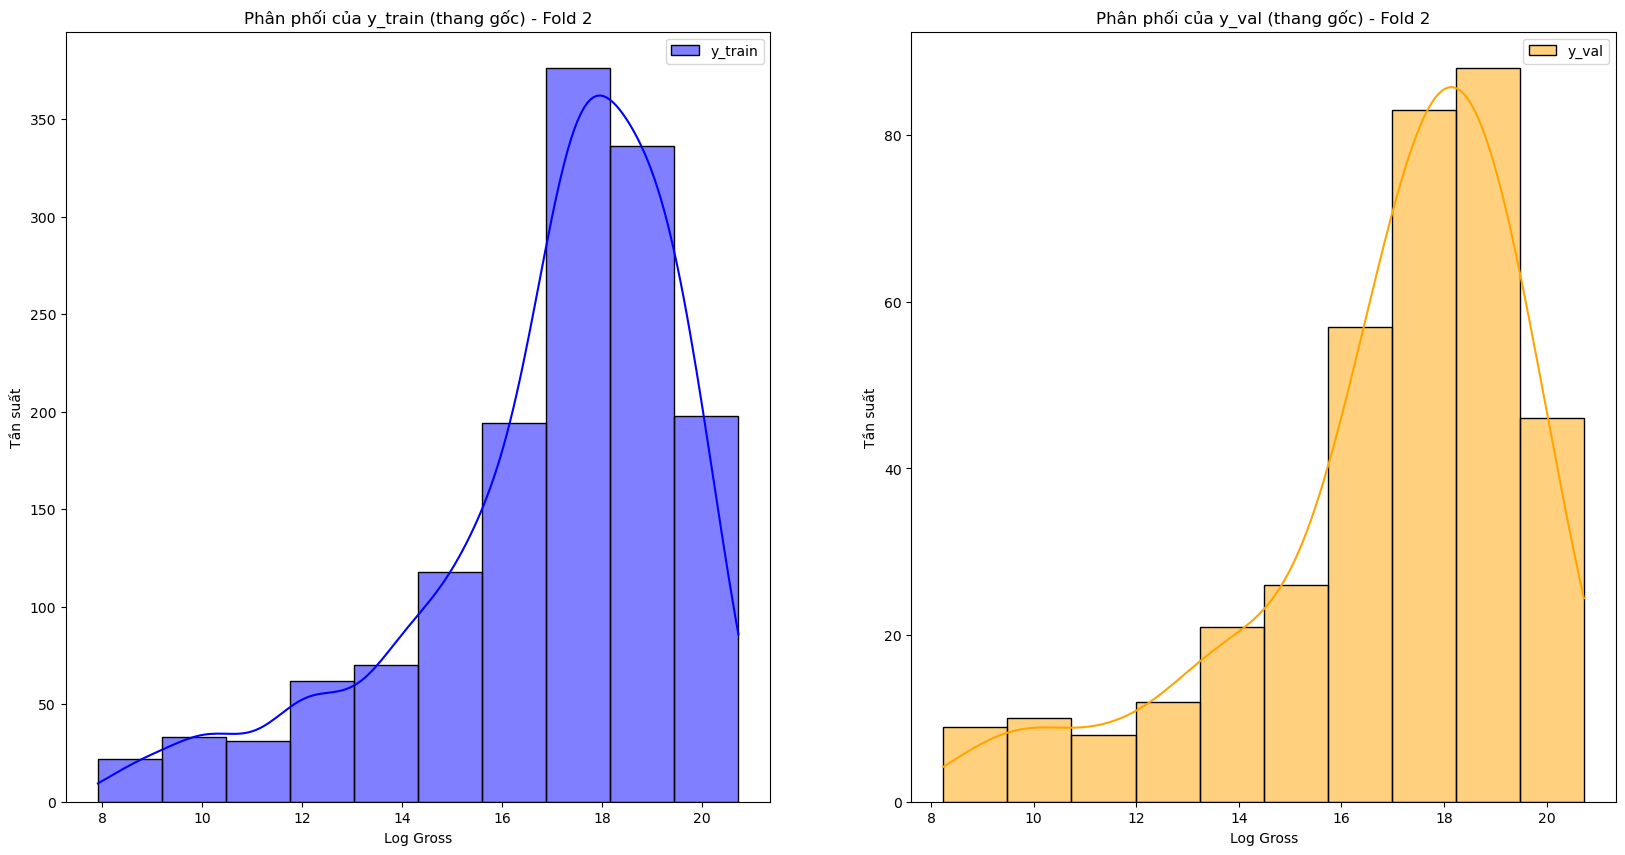

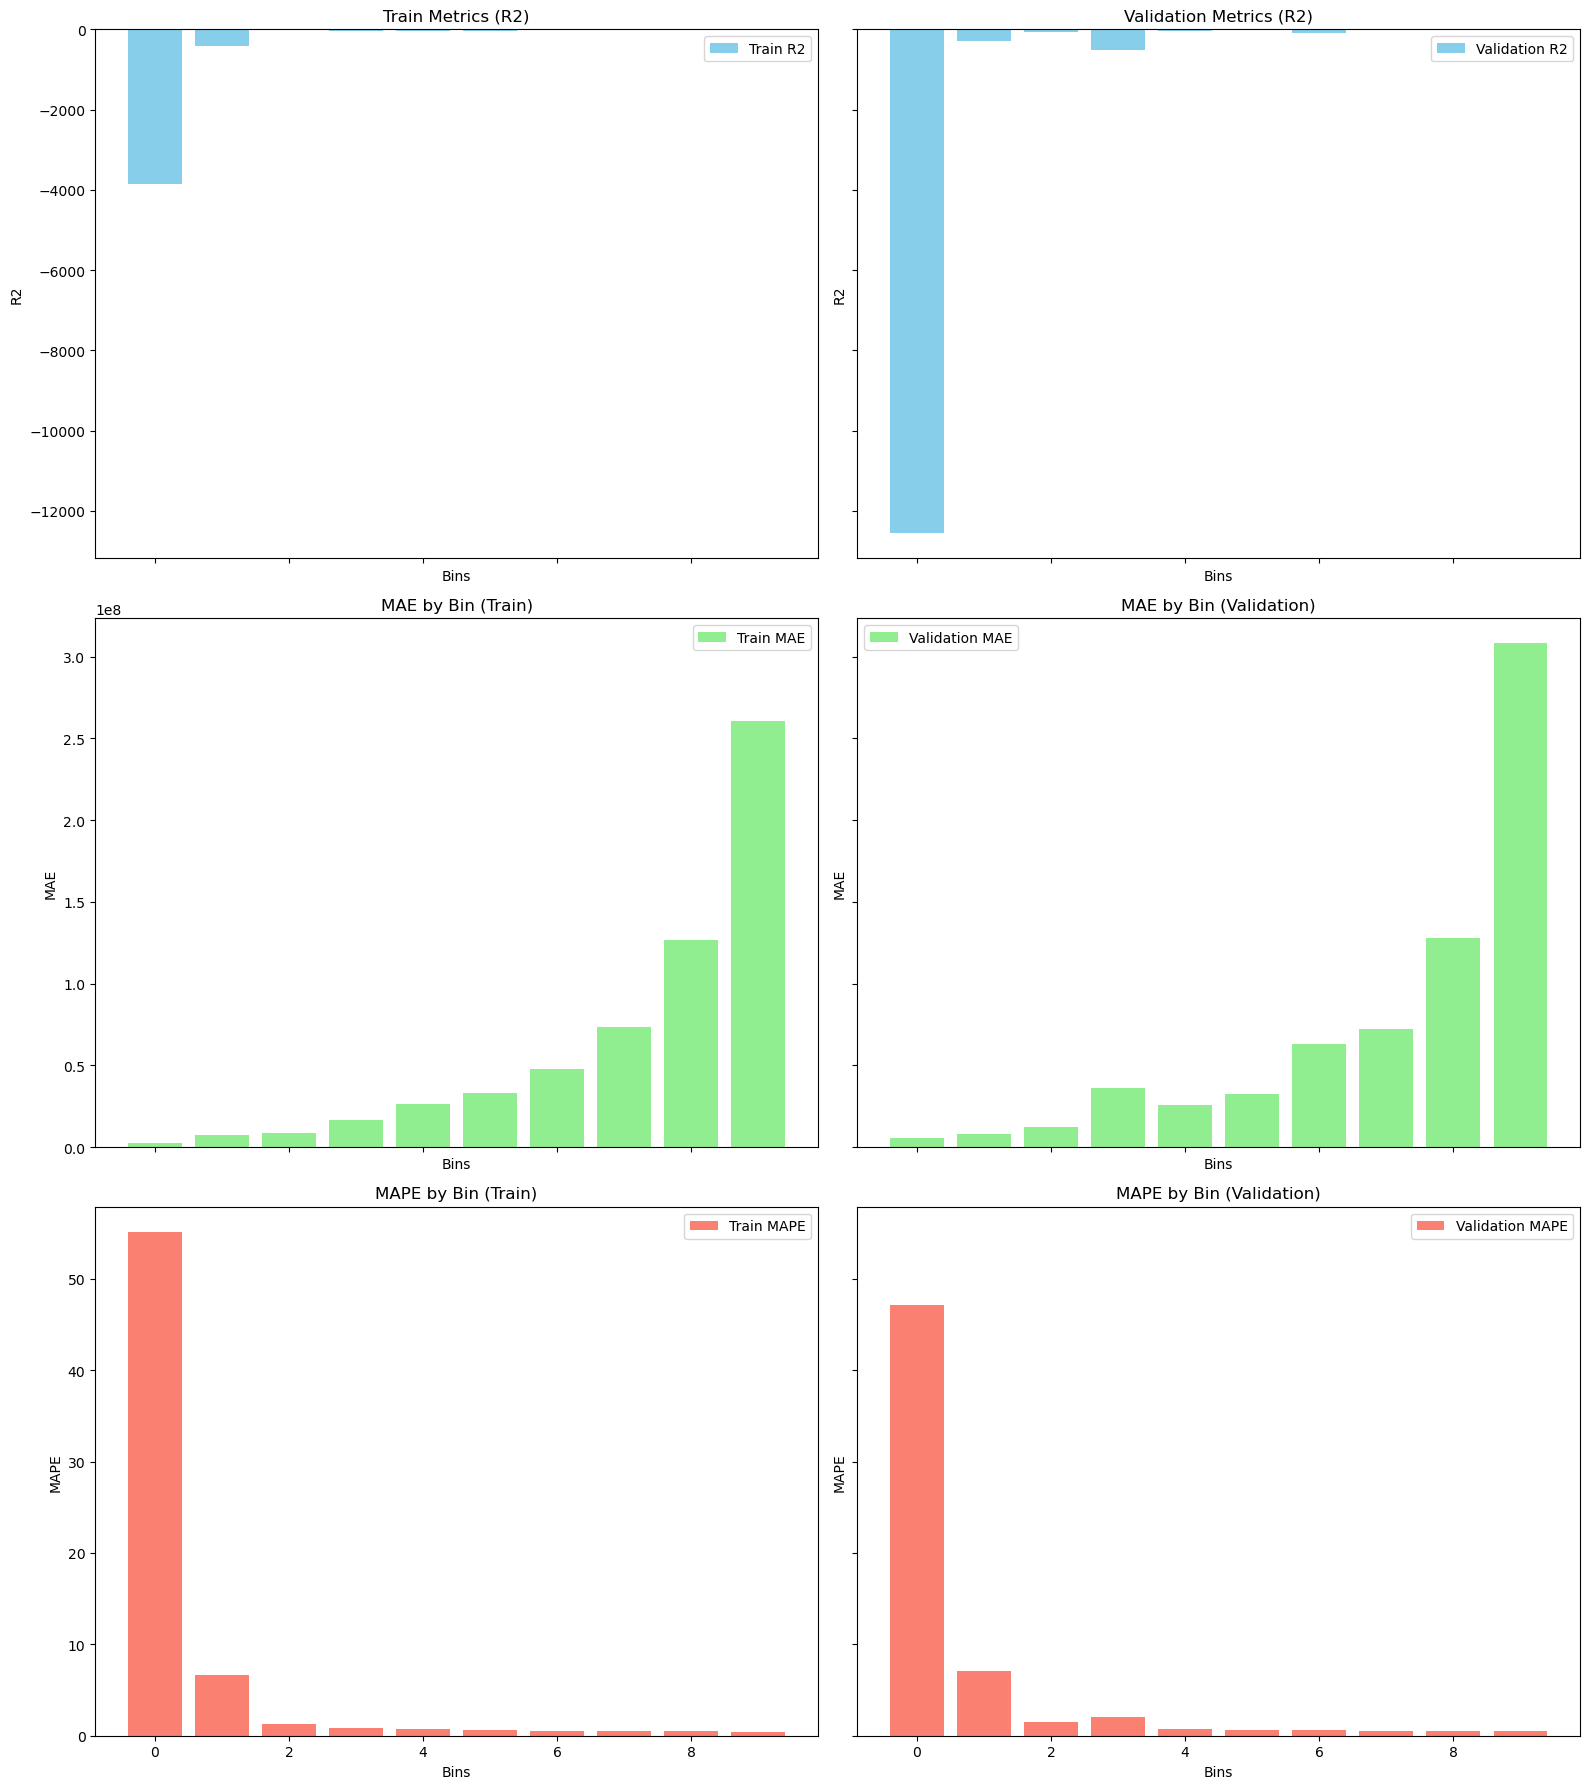


=== Fold 3 ===
✅ Scaler saved to: H:\python\best_models\neural_net\fold_3\scaler.pkl
Training with params: {'patience': 100, 'num_hidden_layers': 2, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 516}
Early stopping at epoch 242
Training with params: {'patience': 150, 'num_hidden_layers': 3, 'learning_rate': 0.001, 'dropout_rate': 0.5, 'batch_size': 128}
Early stopping at epoch 443
Training with params: {'patience': 150, 'num_hidden_layers': 2, 'learning_rate': 0.001, 'dropout_rate': 0.1, 'batch_size': 516}
Early stopping at epoch 298
Training with params: {'patience': 50, 'num_hidden_layers': 3, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'batch_size': 64}
Early stopping at epoch 109
Training with params: {'patience': 150, 'num_hidden_layers': 3, 'learning_rate': 0.001, 'dropout_rate': 0.3, 'batch_size': 256}
Early stopping at epoch 414
Training with params: {'patience': 100, 'num_hidden_layers': 3, 'learning_rate': 0.005, 'dropout_rate': 0.3, 'batch_size': 64}
Early stopp

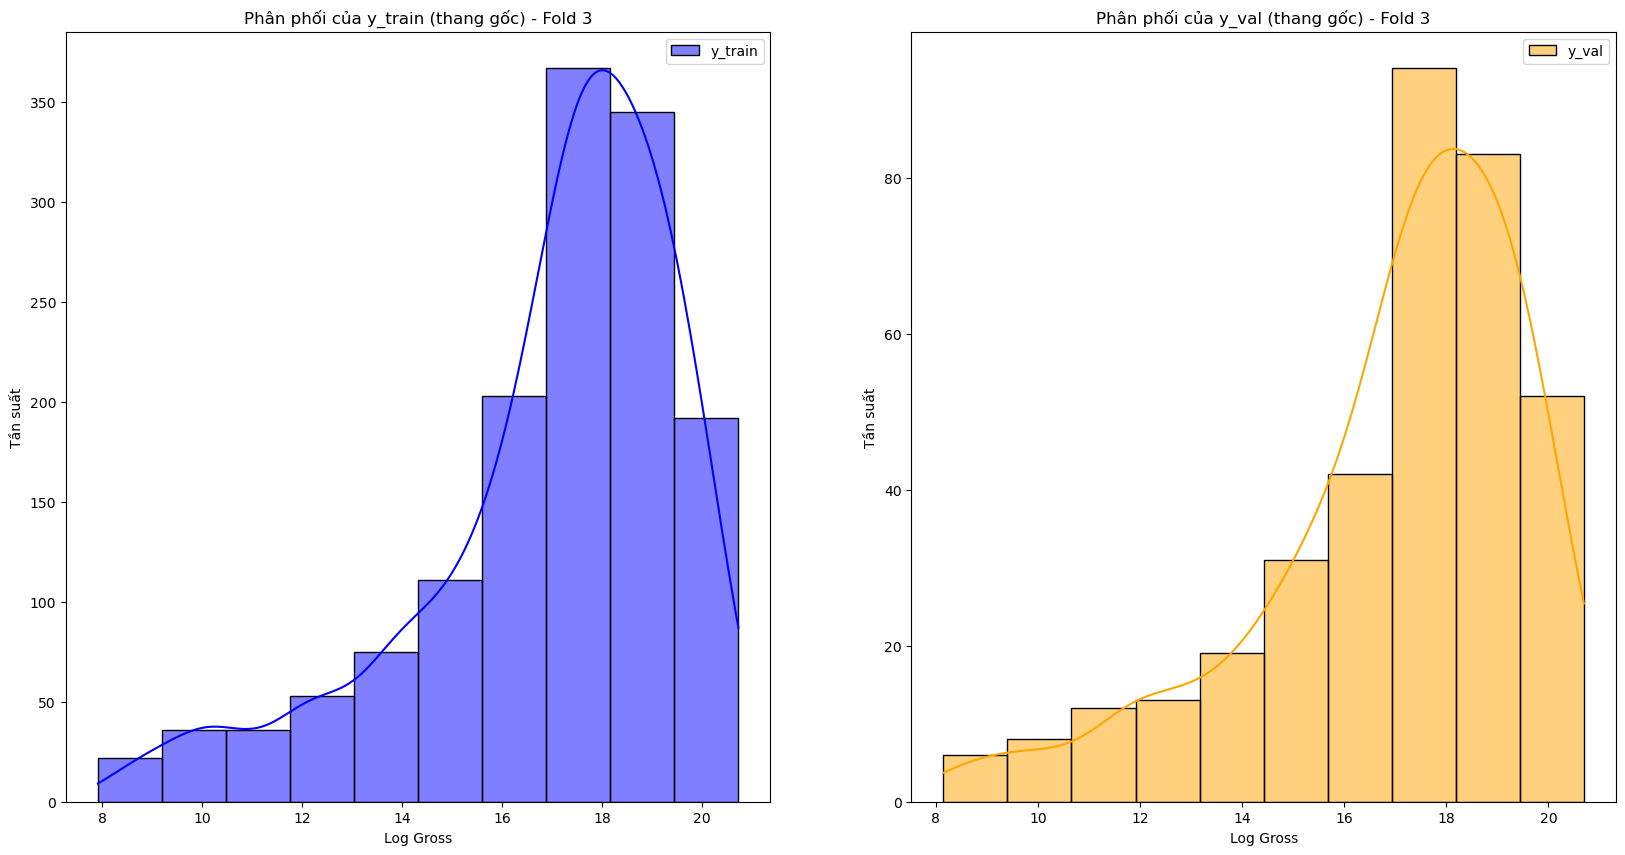

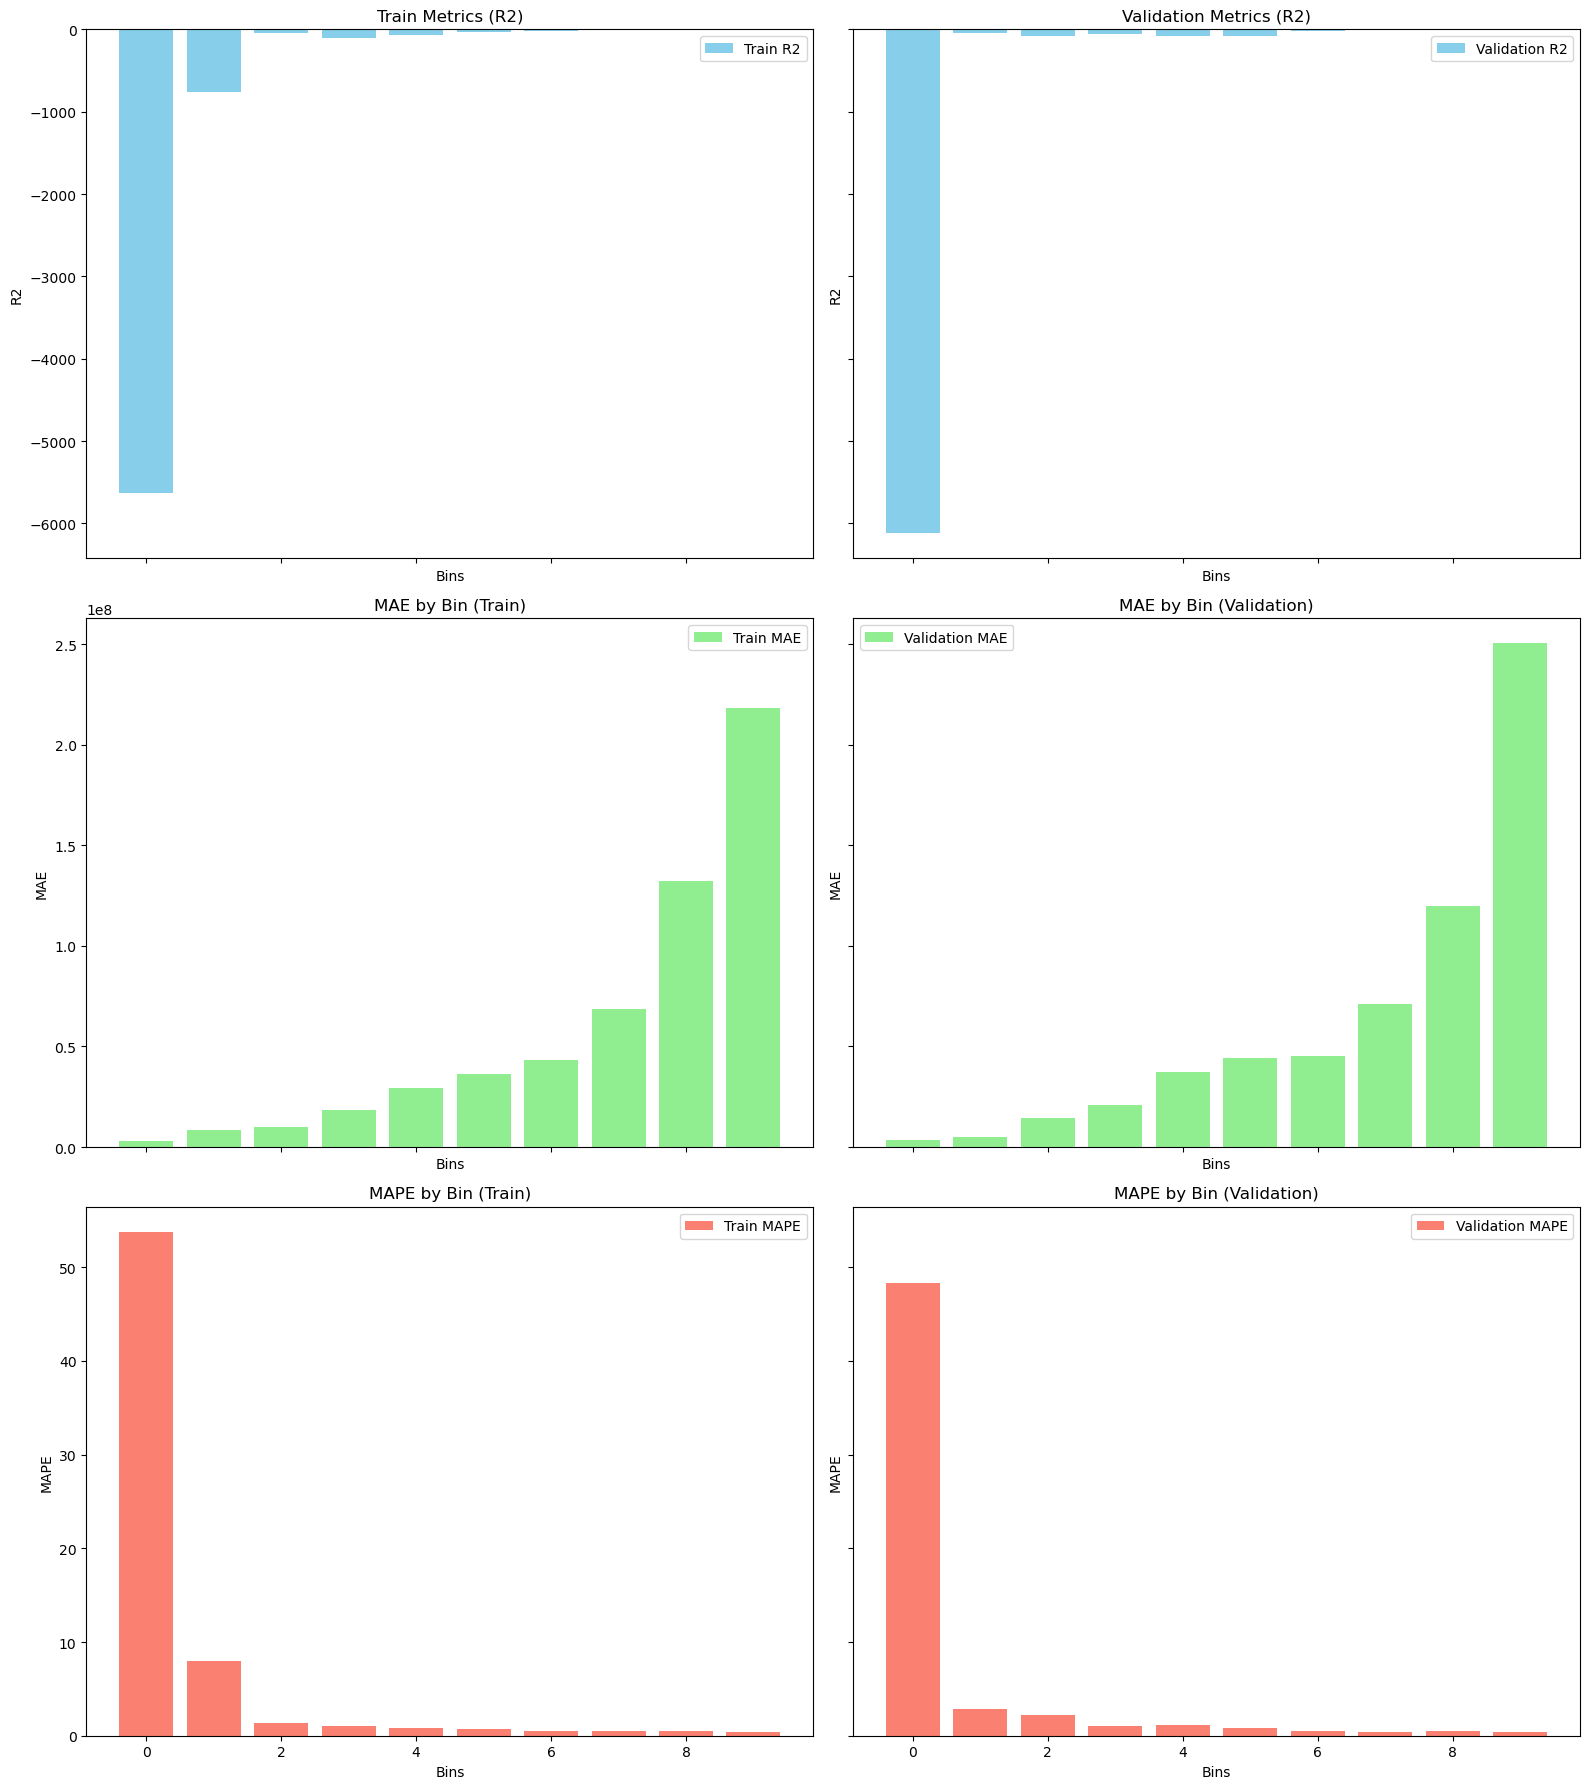


=== Fold 4 ===
✅ Scaler saved to: H:\python\best_models\neural_net\fold_4\scaler.pkl
Training with params: {'patience': 50, 'num_hidden_layers': 3, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 128}
Early stopping at epoch 149
Training with params: {'patience': 100, 'num_hidden_layers': 2, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'batch_size': 256}
Early stopping at epoch 207
Training with params: {'patience': 100, 'num_hidden_layers': 2, 'learning_rate': 0.01, 'dropout_rate': 0.1, 'batch_size': 64}
Early stopping at epoch 177
Training with params: {'patience': 150, 'num_hidden_layers': 3, 'learning_rate': 0.005, 'dropout_rate': 0.5, 'batch_size': 128}
Early stopping at epoch 231
Training with params: {'patience': 150, 'num_hidden_layers': 3, 'learning_rate': 0.005, 'dropout_rate': 0.5, 'batch_size': 256}
Early stopping at epoch 228
Training with params: {'patience': 100, 'num_hidden_layers': 3, 'learning_rate': 0.001, 'dropout_rate': 0.1, 'batch_size': 64}
Early stoppi

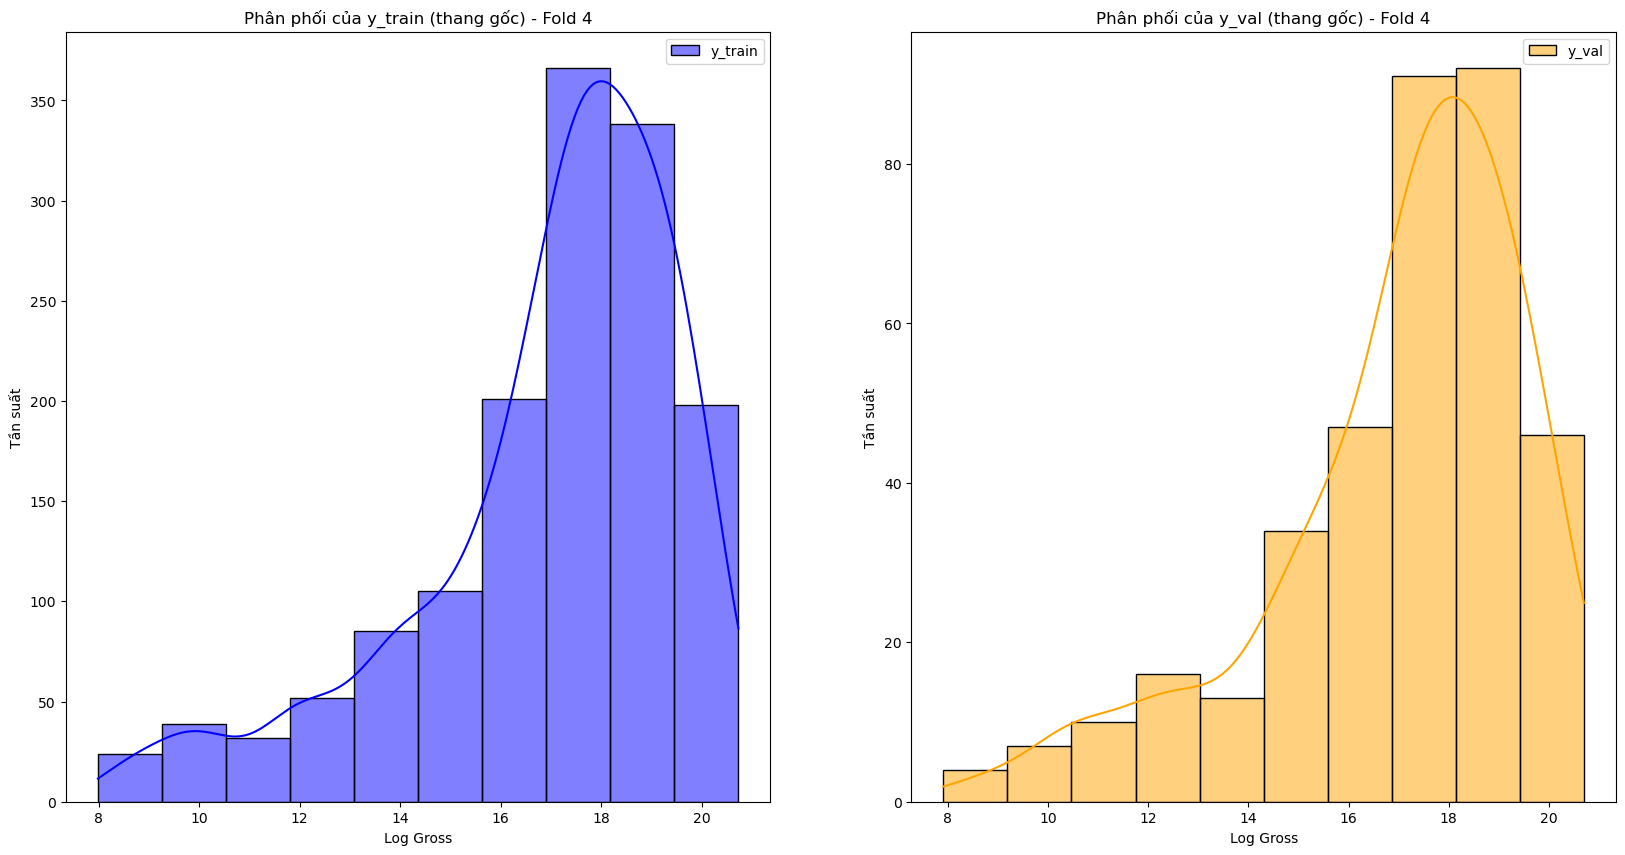

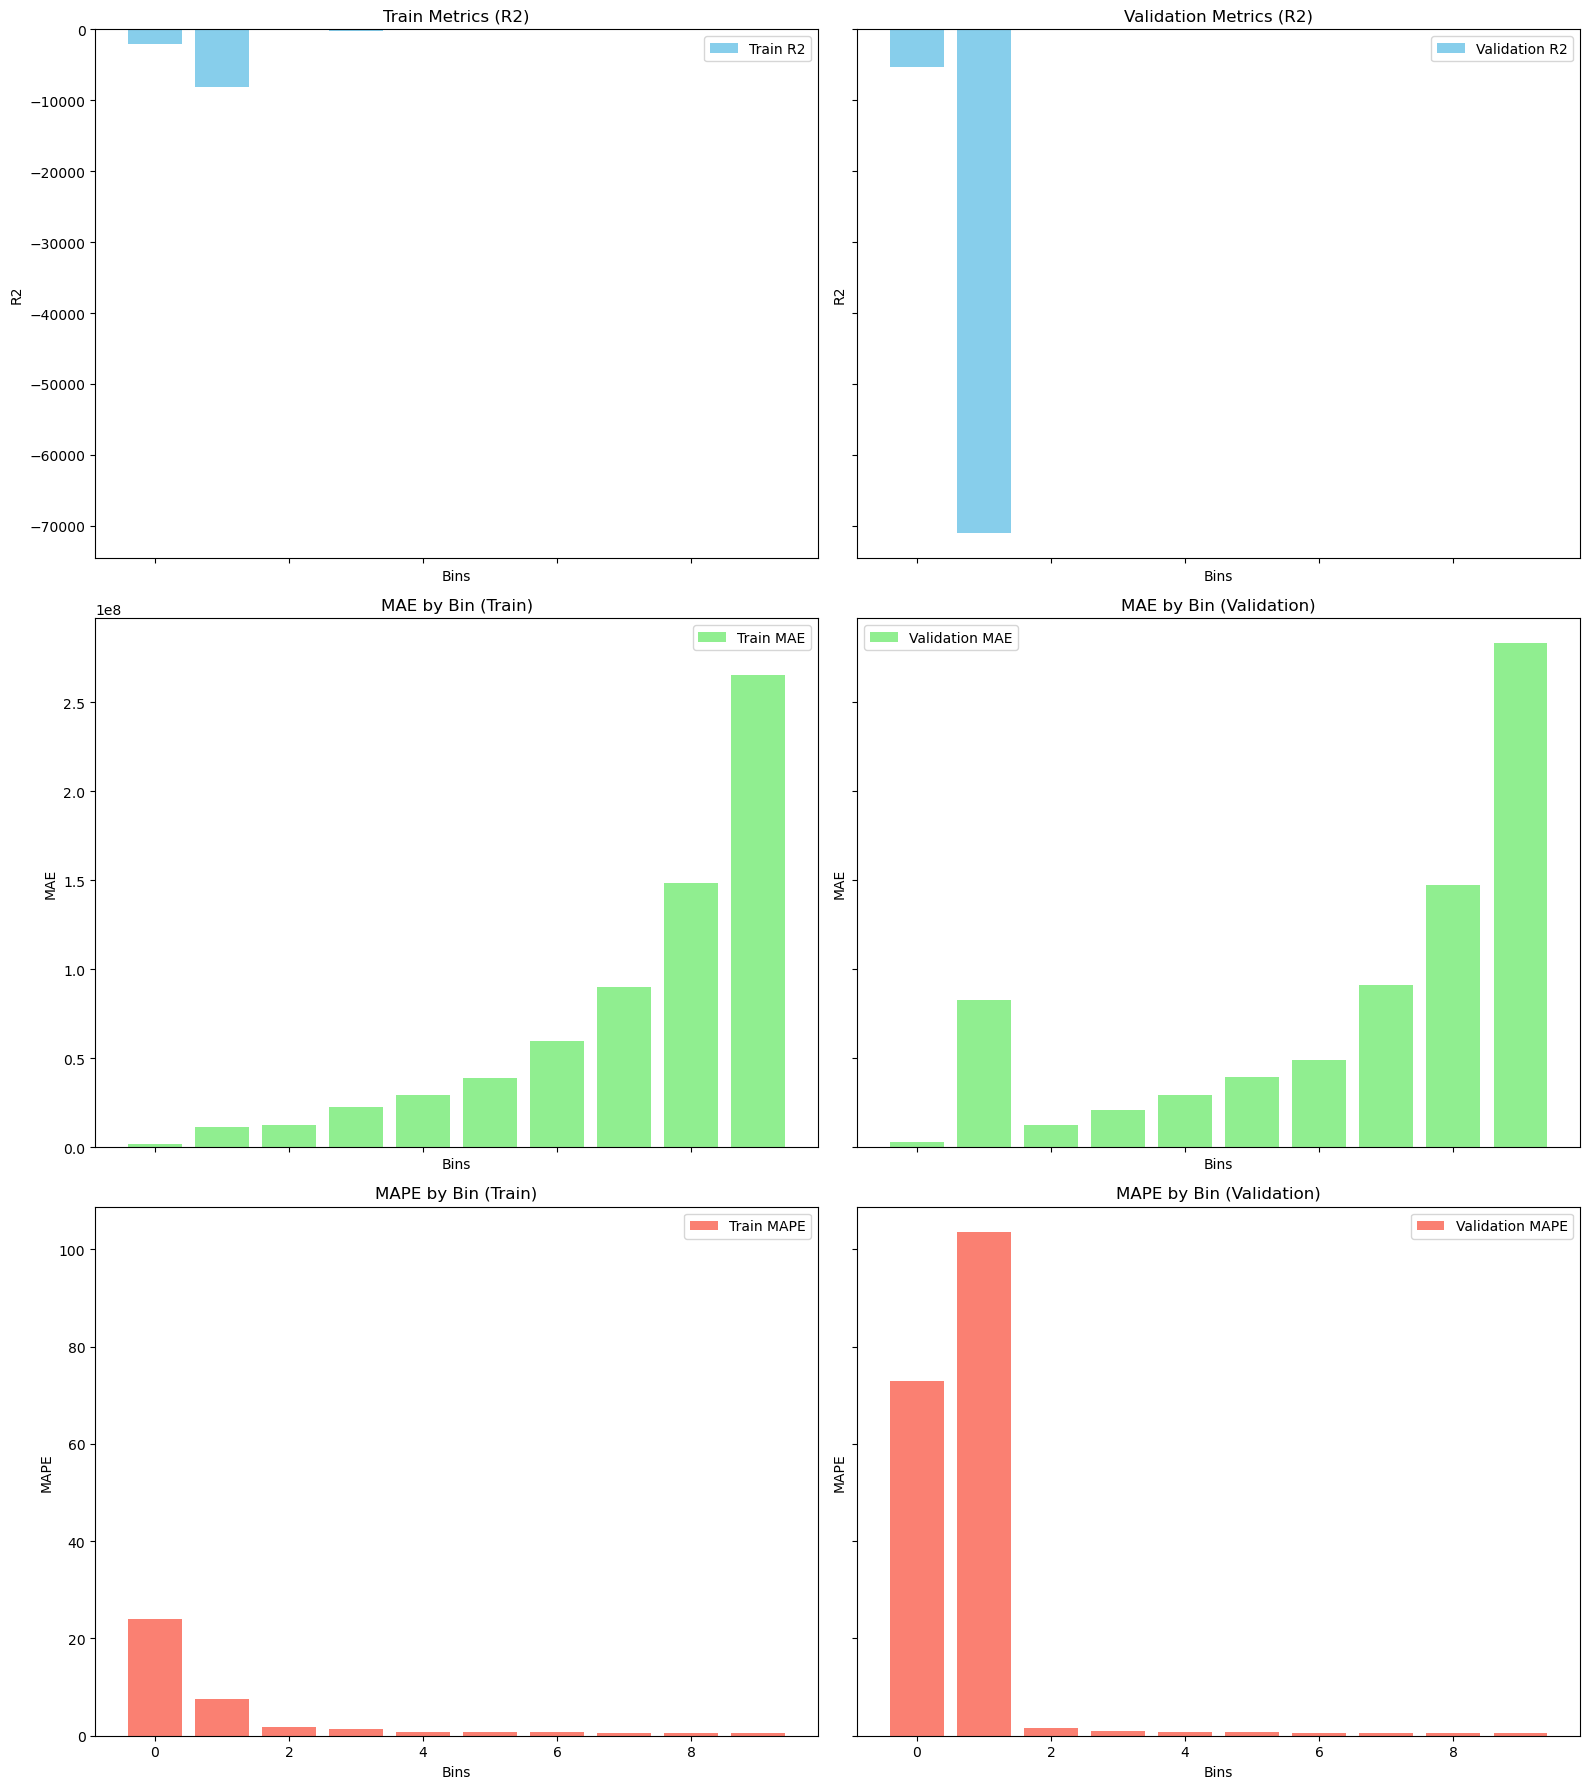


=== Fold 5 ===
✅ Scaler saved to: H:\python\best_models\neural_net\fold_5\scaler.pkl
Training with params: {'patience': 100, 'num_hidden_layers': 3, 'learning_rate': 0.01, 'dropout_rate': 0.2, 'batch_size': 256}
Early stopping at epoch 192
Training with params: {'patience': 100, 'num_hidden_layers': 2, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'batch_size': 128}
Early stopping at epoch 172
Training with params: {'patience': 100, 'num_hidden_layers': 2, 'learning_rate': 0.01, 'dropout_rate': 0.5, 'batch_size': 516}
Early stopping at epoch 201
Training with params: {'patience': 150, 'num_hidden_layers': 2, 'learning_rate': 0.005, 'dropout_rate': 0.2, 'batch_size': 64}
Early stopping at epoch 225
Training with params: {'patience': 50, 'num_hidden_layers': 2, 'learning_rate': 0.01, 'dropout_rate': 0.1, 'batch_size': 64}
Early stopping at epoch 102
Training with params: {'patience': 150, 'num_hidden_layers': 2, 'learning_rate': 0.01, 'dropout_rate': 0.3, 'batch_size': 516}
Early stopping

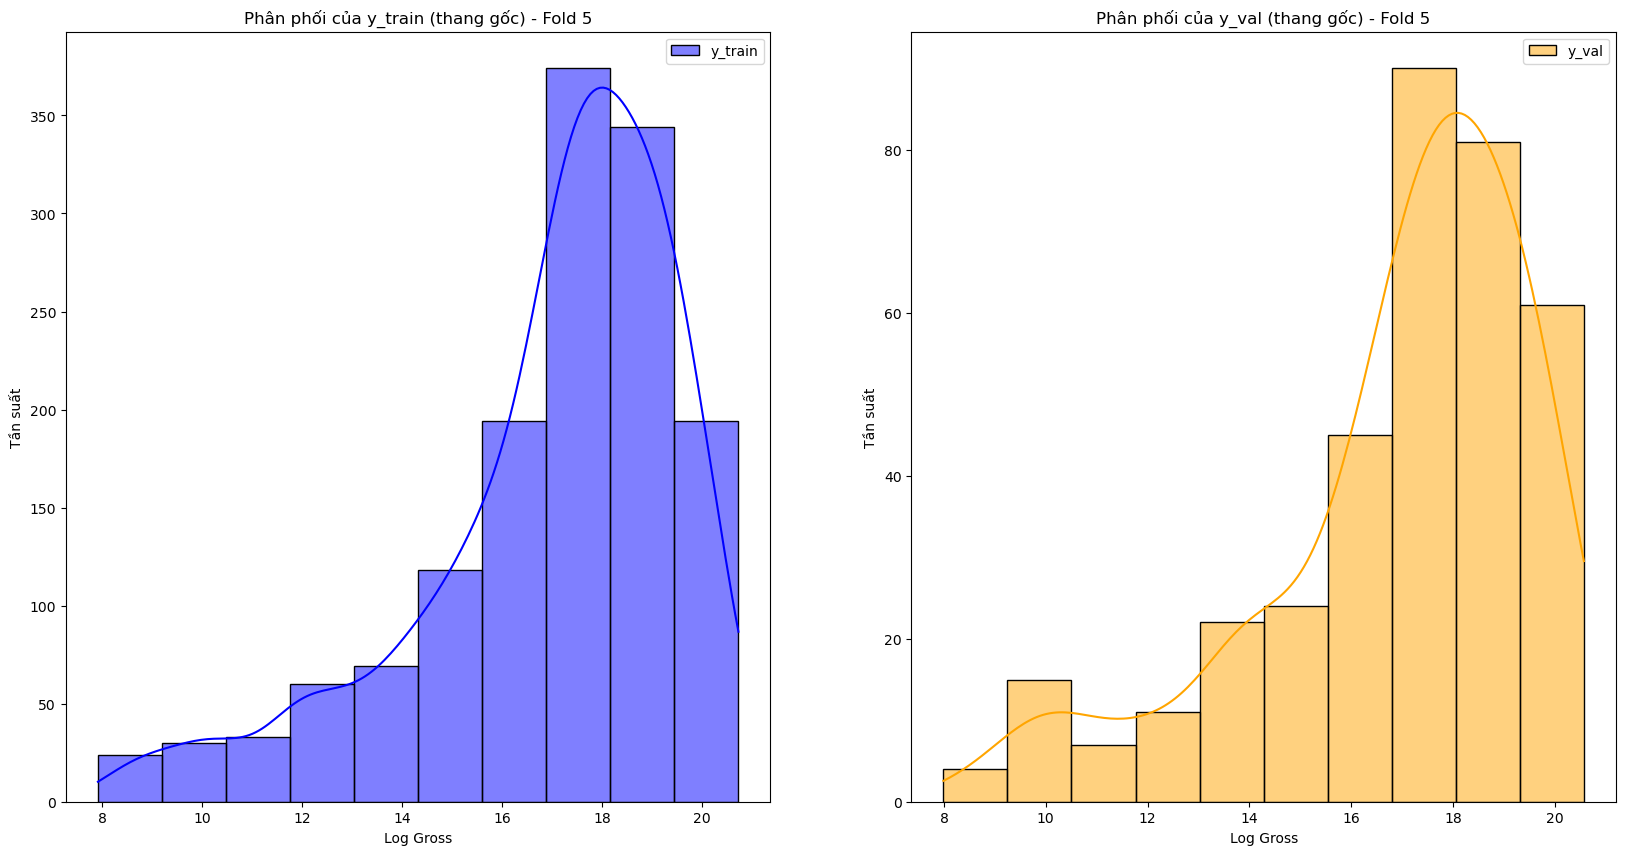

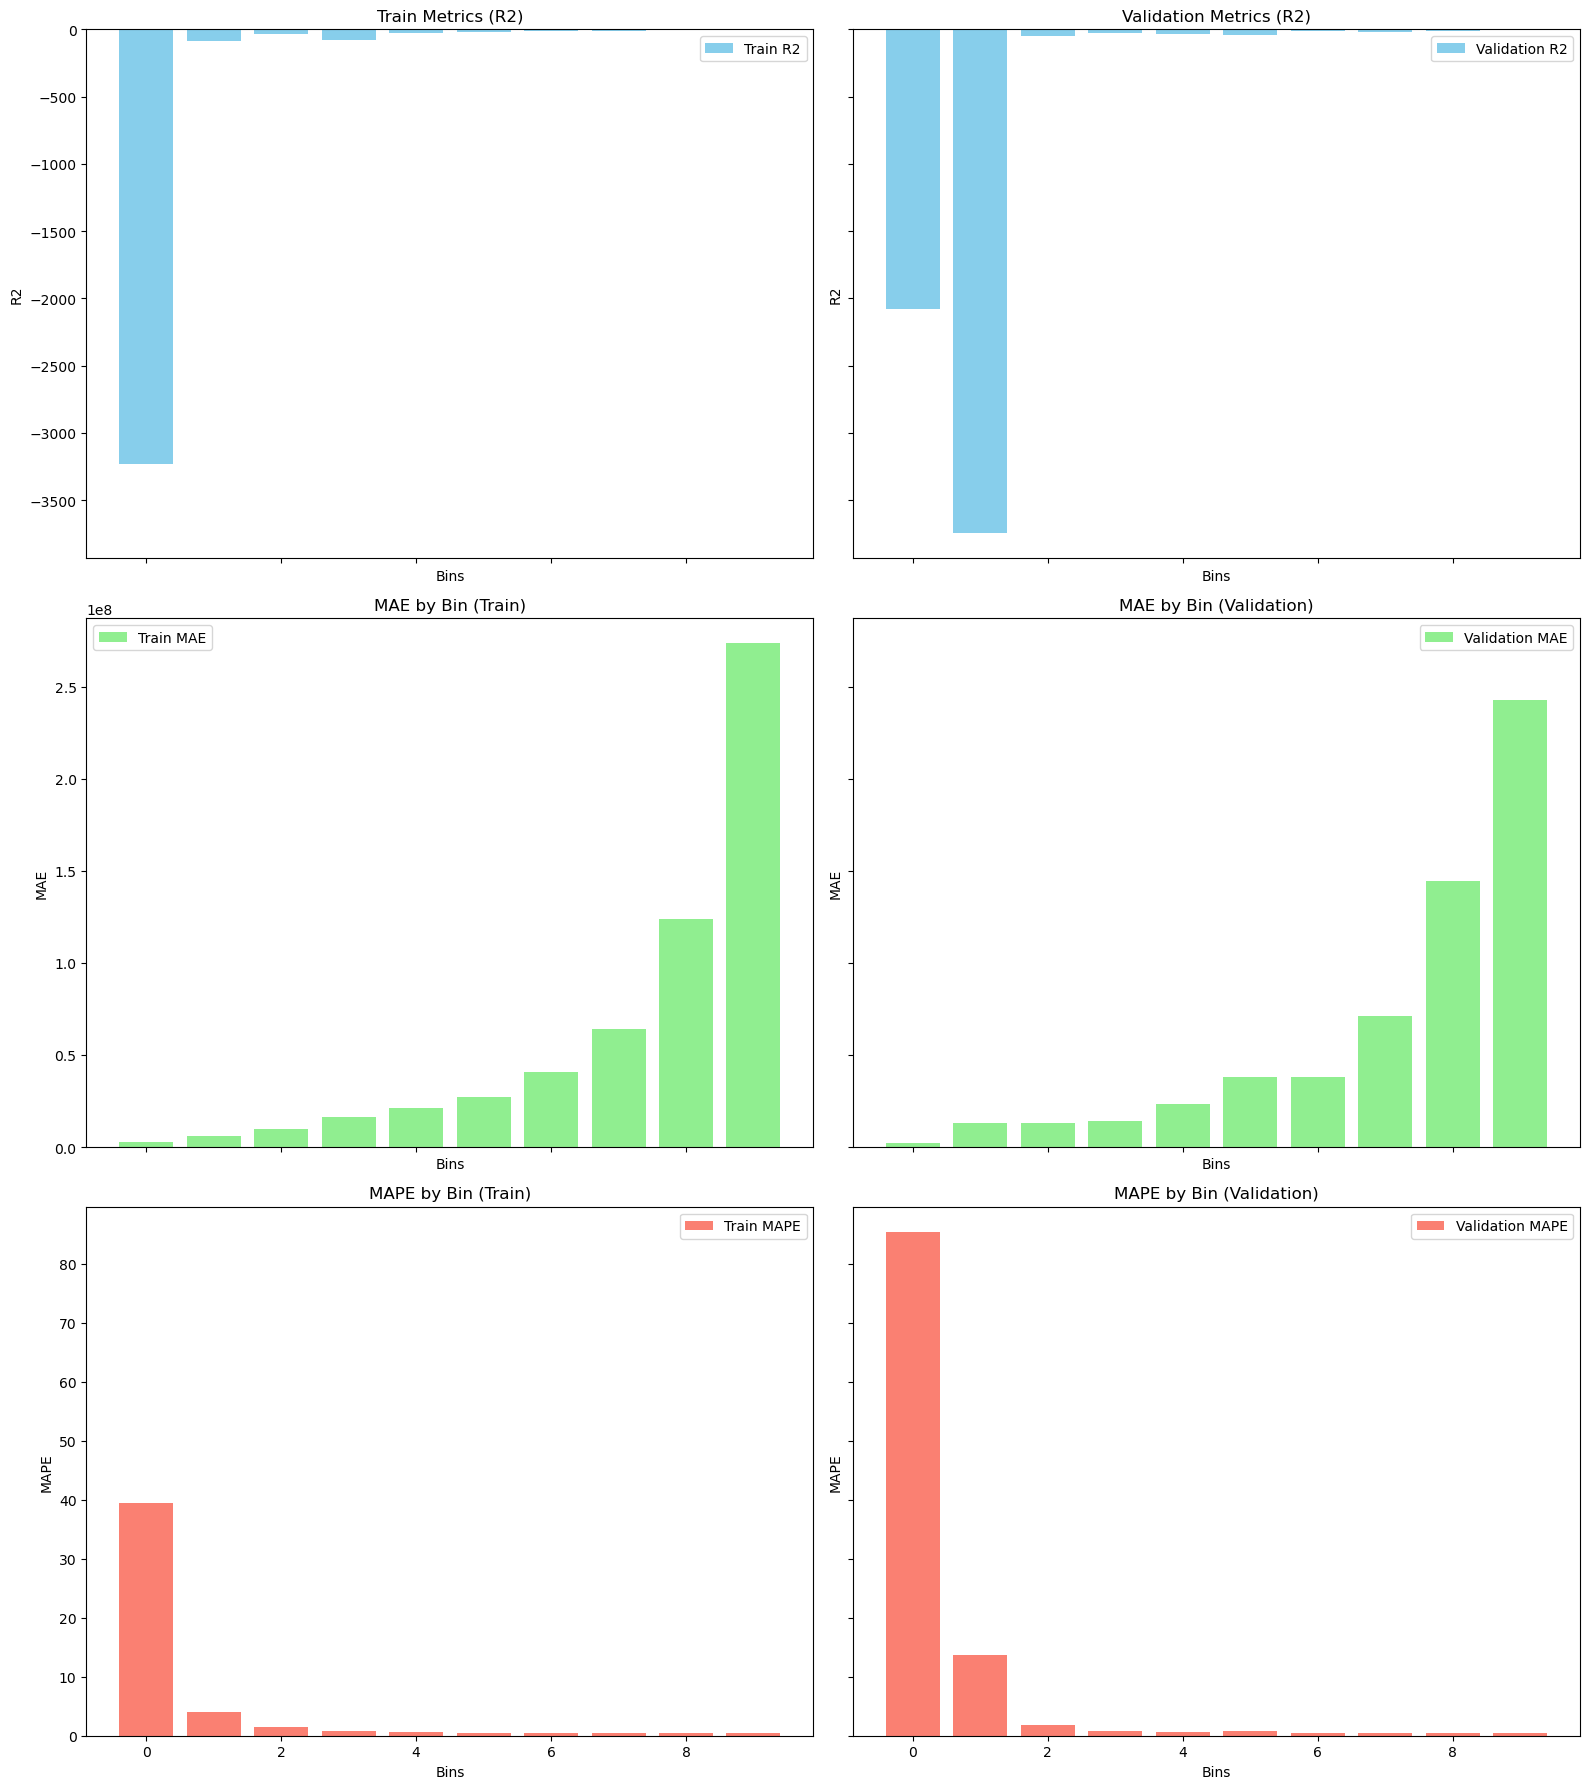

In [5]:
from sklearn.model_selection import ParameterSampler
from settings import FEATURES, TARGET
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
fold_results = []
import json
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["log_gross_bin"])):
    print(f"\n=== Fold {fold + 1} ===")
    df_train = df.iloc[train_idx].copy()
    df_val = df.iloc[val_idx].copy()

    X_train, y_train, X_val, y_val = processing_data(
        df_train, df_val, fold=fold, features=FEATURES, target=TARGET, model_name="neural_net"
    )

    sampler = ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state + fold)
    fold_param_results = []

    for params in sampler:
        val_loss = train_model(X_train, y_train, X_val, y_val, params, fold)
        fold_param_results.append({
            "params": params,
            "val_loss": val_loss
        })

    # Chọn tham số tốt nhất cho fold hiện tại
    best_result = min(fold_param_results, key=lambda x: x["val_loss"])
    best_params = best_result["params"]
    print(f"\nBest params for Fold {fold + 1}: {best_params}")
    print(f"Best val loss: {best_result['val_loss']:.4f}")


    save_path = os.path.join(BEST_MODEL_DIR, f"fold_{fold+1}")
    os.makedirs(save_path, exist_ok=True)

    # Load model tốt nhất vừa lưu
    best_model_path = os.path.join(save_path, "model.pt")
    params_path = os.path.join(save_path, "params.json")
    with open(params_path, "r") as f:
        saved_params = json.load(f)

    # Khởi tạo mô hình với hyperparameter đã lưu
    model = Net(X_train.shape[1],
            num_hidden_layers=saved_params["num_hidden_layers"],
            dropout_rate=saved_params["dropout_rate"]).to(DEVICE)
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # Tensor hoá dữ liệu
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(DEVICE)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(DEVICE)

    # Dự đoán
    with torch.no_grad():
        train_preds = model(X_train_tensor).cpu().numpy().flatten()
        y_train_true = y_train_tensor.cpu().numpy().flatten()

        val_preds = model(X_val_tensor).cpu().numpy().flatten()
        y_val_true = y_val_tensor.cpu().numpy().flatten()

    # Vẽ và lưu kết quả từng fold
    fig, axes = plt.subplots(3, 2, figsize=(16, 18), sharex=True, sharey='row')
    df_train_result,overall_r2_train, overall_mae_train, overall_mape_train = visualize_results(df_train, y_true=y_train_true, y_pred=train_preds, calculate_real_target=True, dataset_label="Train", axes=axes[:, 0])
    df_val_result, overall_r2_val, overall_mae_val, overall_mape_val = visualize_results(df_val, y_true=y_val_true, y_pred=val_preds, calculate_real_target=True, dataset_label="Validation", axes=axes[:, 1])

    axes[0, 0].set_title("Train Metrics (R2)")
    axes[0, 1].set_title("Validation Metrics (R2)")
    plt.tight_layout()
    plt.show()

    # Lưu kết quả vào fold_results
    fold_results.append({
        "fold": fold + 1,
        "best_params": best_params,
        "train_metrics": {
            "overall_r2": overall_r2_train,
            "overall_mae": overall_mae_train,
            "overall_mape": overall_mape_train
        },
        "val_metrics": {
            "overall_r2": overall_r2_val,
            "overall_mae": overall_mae_val,
            "overall_mape": overall_mape_val
        }
    })




In [6]:
# Tính trung bình của các chỉ số train/val qua 5 fold
train_r2_avg = np.mean([r["train_metrics"]["overall_r2"] for r in fold_results])
train_mae_avg = np.mean([r["train_metrics"]["overall_mae"] for r in fold_results])
train_mape_avg = np.mean([r["train_metrics"]["overall_mape"] for r in fold_results])

val_r2_avg = np.mean([r["val_metrics"]["overall_r2"] for r in fold_results])
val_mae_avg = np.mean([r["val_metrics"]["overall_mae"] for r in fold_results])
val_mape_avg = np.mean([r["val_metrics"]["overall_mape"] for r in fold_results])

print("\n=== Average Train Metrics Across 5 Folds ===")
print(f"Overall R2: {train_r2_avg:.4f}")
print(f"Overall MAE: {train_mae_avg:.4f}")
print(f"Overall MAPE: {train_mape_avg:.4f}")

print("\n=== Average Validation Metrics Across 5 Folds ===")
print(f"Overall R2: {val_r2_avg:.4f}")
print(f"Overall MAE: {val_mae_avg:.4f}")
print(f"Overall MAPE: {val_mape_avg:.4f}")


=== Average Train Metrics Across 5 Folds ===
Overall R2: 0.6104
Overall MAE: 59940211.2000
Overall MAPE: 5.9321

=== Average Validation Metrics Across 5 Folds ===
Overall R2: 0.5159
Overall MAE: 66063330.4000
Overall MAPE: 9.7125
